In [1]:
# Imports needed
from math import sin, cos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # for plotting
from scipy.integrate import odeint

from probDE.utils.utils import root_gen
from probDE.Kalman.kalman_multi_solver import kalman_multi_solver

In [ ]:
# RHS of ODE
def ode_fun(x_t, t):
    return sin(2*t) - x_t[0]

# LHS vector of ODE
w_mat = np.array([[0.0, 0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
q = 2 # ODE order
p = q+2 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [L,U].
N = 100 # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
L = 0
U = 10 

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
mu = np.zeros(p)

# Initial value, x0, for the IVP
a = np.array([[-1.0, 0.0, 1.0]])

In [ ]:
# Exact Solution for x_t^{(0)}
def ode_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

# Exact Solution for x_t^{(1)}
def ode_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

# Get exact solutions for x^{(0)}, x^{(1)}
tseq = np.linspace(L, U, N)
exact_x = np.zeros(N)
exact_x1 = np.zeros(N)
for t in range(N):
    exact_x[t] = ode_exact_x(tseq[t])
    exact_x1[t] = ode_exact_x1(tseq[t])
exact = np.array(list(zip(exact_x, exact_x1)))

In [2]:
def fitz(X_t, t):
    a = .2
    b = .2
    c = 3
    V, R = X_t
    return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]

In [3]:
# RHS of ODE
def fitz2(X_t, t):
    p = 3
    a = .2
    b = .2
    c = 3
    V, R = X_t[p*0], X_t[p*1]
    return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]

# LHS Matrix of ODE
w_mat = np.array([[0,1], [0,1]])

# These parameters define the order of the ODE and the CAR(p) process
n = 2 # Number of variates
q = 1 # ODE order
p = q+2 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [L,U].
Nlst = [8000, 4000, 2000, 800, 400] # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
L = 0
U = 40

# Now we need the parameters for the solver
# First we need to generate roots, rho, for the CAR(p) priors
# We need a set of roots and sigma for each variate
roots = root_gen(100, p)
rootlst = [roots]*n
# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = .5
sigmalst = [sigma]*n

# Initial value, a, for the IVP
x0 = [-1, 1]
v0 = fitz(x0, 0)
mu = np.zeros(n*p)
a = np.array(list(zip(x0, v0)))

# Run the solver to get an approximation
Xn, Xn_mean, Xn_var = kalman_multi_solver(fitz2, L, U, Nlst[-2], mu, sigmalst, rootlst, w_mat, a)

In [4]:
tseq = np.linspace(L, U, Nlst[-2])
exact = odeint(fitz, x0, tseq)

In [5]:
tauseq = np.linspace(100, 300, 9)
sigmaseq = np.linspace(0.01, 0.5, 9)

def recon_err(fun, L, U, N, mu, w_mat, a, tauseq, sigmaseq, exact, n, p):
    std = np.zeros((n, len(tauseq), len(sigmaseq)))
    tseq = np.linspace(L, U, N)
    for i, tau in enumerate(tauseq):
        for j, sigma in enumerate(sigmaseq):
            roots = root_gen(tau, p)
            rootlst = [roots]*n
            sigmalst = [sigma]*n
            try:
                Xn, _,_ = kalman_multi_solver(fun, L, U, N, mu, sigmalst, rootlst, w_mat, a)
                std[:, i, j]= np.std(exact - Xn[:, list(range(0,p*n,p))], axis=0)
            except:
                std[:, i, j] = np.nan
            
    return std
rec_err = recon_err(fitz2, L, U, Nlst[-2], mu, w_mat, a, tauseq, sigmaseq, exact, n, p)

In [6]:
rec_err_1 = pd.DataFrame(rec_err[0], index=tauseq, columns=sigmaseq)
rec_err_2 = pd.DataFrame(rec_err[1], index=tauseq, columns=sigmaseq)

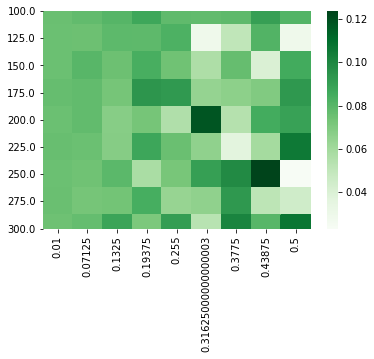

In [7]:
axs = sns.heatmap(rec_err_1, cmap="Greens", mask=np.isnan(rec_err[0]))
axs.set_facecolor('black')

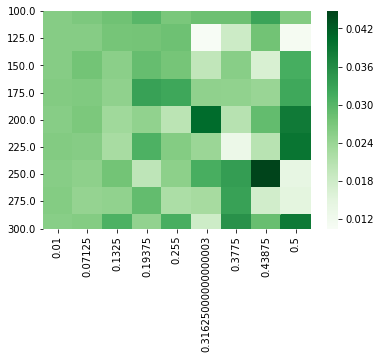

In [8]:
axs = sns.heatmap(rec_err_2, cmap="Greens", mask=np.isnan(rec_err[1]))
axs.set_facecolor('black')